**Some code in this notebook does not work in the Cocalc Jupyter interface, please run this using a Classic Jupyter Notebook**

In [1]:
# includes some css for styling the notebook, not important
from IPython.display import display, HTML

display(HTML(data="""

<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

<style>
 th{font-size:14px}
 td{font-size:14px}
.tleft td{text-align:left;}
.tleft th{text-align:left;}
.tbrdtop td{border-top: thin solid;}
.tc td{text-align:center;}
</style>

"""))

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import interpolate
from scipy.optimize import minimize_scalar, minimize
import babel.numbers as numbers
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import plotly
from ipywidgets import *
from sklearn.datasets import make_classification, make_circles #libraries to generate data
from sklearn.neural_network import MLPClassifier #to use neural net
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from IPython.display import display

sns.set_style("darkgrid")

# Gradient Descent and Local Minima

In [3]:
# unfold to see code for interactive graph, not important to understand

def f(x):
    return x**5 - x**4 - 18*x**3 + 16*x**2 + 32*x - 2 

def fprime(x):
    return 5*x**4 - 4*x**3 - 54*x**2 + 32*x + 32 

xmin = -4
xmax = 3.6

steps = 200
dt = 0.001

def descend(x):
    trajectory = np.zeros(steps)
    trajectory[0] = x
    for j in range(1,steps):
        trajectory[j] = trajectory[j-1] - dt*fprime(trajectory[j-1])
        trajectory[j] = np.maximum(xmin,trajectory[j])
        trajectory[j] = np.minimum(xmax,trajectory[j])
    return trajectory

traj = descend(0)
ytraj = f(traj)

x = np.linspace(-4,4,1001)
y = f(x)
trace0 = go.Scatter(x = x, y = y, mode = 'lines',hoverinfo = 'none')

idx = 501
trace1 = go.Scatter(x = [x[idx]], 
                    y = [y[idx]],
                    hoverinfo = 'skip',
                    mode = 'markers',
                    marker = dict(
                                size = 10,
                                color = 'green',
                                line = dict(
                                    width = 2,
                                    color = 'rgb(0, 0, 0)'
                                            )
                    )
                   )

trace2 = go.Scatter( x = traj, y = ytraj, mode = 'lines',line = dict(width=3,color='black'),hoverinfo='skip')

trace3 = go.Scatter(x = [traj[-1]], 
                    y = [ytraj[-1]],
                    hoverinfo = 'skip',
                    mode = 'markers',
                    marker = dict(
                                size = 10,
                                color = 'red',
                                line = dict(
                                    width = 2,
                                    color = 'rgb(0, 0, 0)'
                                            )
                    )
                   )

data = [trace0, trace1, trace2, trace3]

layout = go.Layout(width=500,height=500,
                   xaxis=dict(range=[-4, 4]),
                   yaxis=dict(range=[-150, 250]),
                   showlegend = False,
                   hovermode = 'closest'
)

fig = go.Figure(data=data, layout=layout)
fw = go.FigureWidget(data=fig.data, layout=fig.layout)

# create our callback function
def update_point(trace, points, selector):
    if trace.mode=='lines':
        with fw.batch_update():
            x0 = fw.data[0].x[points.point_inds[0]]
            y0 = fw.data[0].y[points.point_inds[0]]
            traj = descend(x0)
            ytraj = f(traj)
            # update trace1 (green point)
            fw.data[1].x = [x0]
            fw.data[1].y = [y0]
            # update trace 2 (black curve)
            fw.data[2].x = traj
            fw.data[2].y = ytraj
            # update trace 3
            fw.data[3].x = [traj[-1]]
            fw.data[3].y = [ytraj[-1]]
            #f.layout.title = {'text':trace}

fw.data[0].on_click(update_point)
fw

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'mode': 'lines',
              'type': 'scatte…

# Machine Learning and Local Minima

This demo is inspired by the <a href="https://playground.tensorflow.org/"> Neural Network Playground from Tensorflow.</a> The Playground is a seriously fun and interesting tool for beginning to develop some understanding of using neural networks for classification.  **Go to the link above and play, or use the embedded version below**

In [4]:
# embed neural network playground
from IPython.display import IFrame    
IFrame("http://playground.tensorflow.org/", width=1100, height = 700)

# The Rastrigin Function

The Rastrigin function is a common test case for optimization algorithms because it has many local minima.  The definition of the function is 
$$f(\mathbf{x})=10 n+\sum_{i=1}^{n}\left[x_{i}^{2}-10 \cos \left(2 \pi x_{i}\right)\right]$$
Where $n$ is the dimensionality of input vector $\mathbf{x}$.  For instance if $n=2$ then $\mathbf{x} = (x_1, x_2)$.  

The domain is restricted so that each $x_i \in [-5.12, 5.12].$ 

The global minimum value is 0 and occurs when $x_i = 0$ for all $i.$

You can count from the graph that there are 11 local minima and 1 global minimum.  

The number of local minima increases exponentially as $11^n$ but there is only global minimum.

Here is a graph of the the Rastrigin function with dimension $n=1.$ 

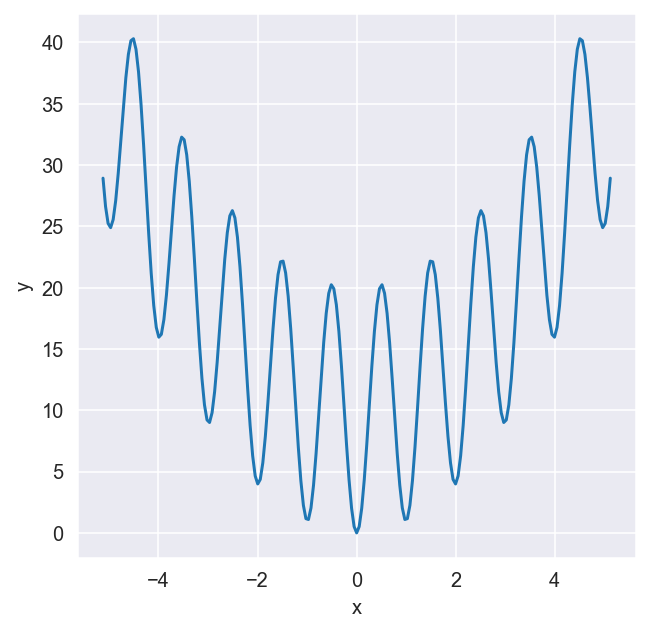

In [5]:
# unfold to see code for 1D Rastrigin
def rastrigin_1D(x):
    return(10 + x**2 - 10 * np.cos(2*np.pi*x))

x = np.linspace(-5.12,5.12,201)
y = rastrigin_1D(x)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot(x,y)
ax.set_xlabel('x');
ax.set_ylabel('y');

In [6]:
# unfold to see code for interactive graph, not important to understand
import plotly.graph_objs as go
import plotly.offline as py
import plotly

from ipywidgets import interactive, HBox, VBox

import numpy as np

def f(x):
    return 10 + x**2 - 10 * np.cos(2*np.pi*x)

def fprime(x):
    return 2*x + 20*np.pi*np.sin(2*np.pi*x)

xmin = -5.12
xmax = 5.12

steps = 200
dt = 0.001

def descend(x):
    trajectory = np.zeros(steps)
    trajectory[0] = x
    for j in range(1,steps):
        trajectory[j] = trajectory[j-1] - dt*fprime(trajectory[j-1])
        trajectory[j] = np.maximum(xmin,trajectory[j])
        trajectory[j] = np.minimum(xmax,trajectory[j])
    return trajectory

traj = descend(1.6384)
ytraj = f(traj)

x = np.linspace(-5.12,5.12,1001)
y = f(x)
trace0 = go.Scatter(x = x, y = y, mode = 'lines',hoverinfo = 'none')

idx = 660
trace1 = go.Scatter(x = [x[idx]], 
                    y = [y[idx]],
                    hoverinfo = 'skip',
                    mode = 'markers',
                    marker = dict(
                                size = 10,
                                color = 'green',
                                line = dict(
                                    width = 2,
                                    color = 'rgb(0, 0, 0)'
                                            )
                    )
                   )

trace2 = go.Scatter( x = traj, y = ytraj, mode = 'lines',line = dict(width=3,color='black'),hoverinfo='skip')

trace3 = go.Scatter(x = [traj[-1]], 
                    y = [ytraj[-1]],
                    hoverinfo = 'skip',
                    mode = 'markers',
                    marker = dict(
                                size = 10,
                                color = 'red',
                                line = dict(
                                    width = 2,
                                    color = 'rgb(0, 0, 0)'
                                            )
                    )
                   )

data = [trace0, trace1, trace2, trace3]

layout = go.Layout(title='1D Rastrigin Function',width=600,height=600,
                   xaxis=dict(range=[-5.12, 5.12]),
                   yaxis=dict(range=[-2, 42]),
                   showlegend = False,
                   hovermode = 'closest'
)

fig = go.Figure(data=data, layout=layout)
fw = go.FigureWidget(data=fig.data, layout=fig.layout)

# create our callback function
def update_point(trace, points, selector):
    if trace.mode=='lines':
        with fw.batch_update():
            x0 = fw.data[0].x[points.point_inds[0]]
            y0 = fw.data[0].y[points.point_inds[0]]
            traj = descend(x0)
            ytraj = f(traj)
            # update trace1 (green point)
            fw.data[1].x = [x0]
            fw.data[1].y = [y0]
            # update trace 2 (black curve)
            fw.data[2].x = traj
            fw.data[2].y = ytraj
            # update trace 3
            fw.data[3].x = [traj[-1]]
            fw.data[3].y = [ytraj[-1]]
            #f.layout.title = {'text':trace}

fw.data[0].on_click(update_point)
fw

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'mode': 'lines',
              'type': 'scatte…

In [7]:
# plot of 2D Rastrigin with contours, uses Plotly
x = np.linspace(-5.12, 5.12, 201)     
y = np.linspace(-5.12, 5.12, 201)     
X, Y = np.meshgrid(x, y) 
Z = (X**2 - 10 * np.cos(2 * np.pi * X)) + \
  (Y**2 - 10 * np.cos(2 * np.pi * Y)) + 20

data = [
    go.Surface( x = X, y = Y, z = Z, colorscale = 'Jet',
        contours=go.surface.Contours(
            z=go.surface.contours.Z(
              show=True,
              usecolormap=True,
              highlightcolor="#42f462",
              project=dict(z=True)
            )
        )
    )
]

layout = go.Layout(title='2D Rastrigin',width=600,height=600)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

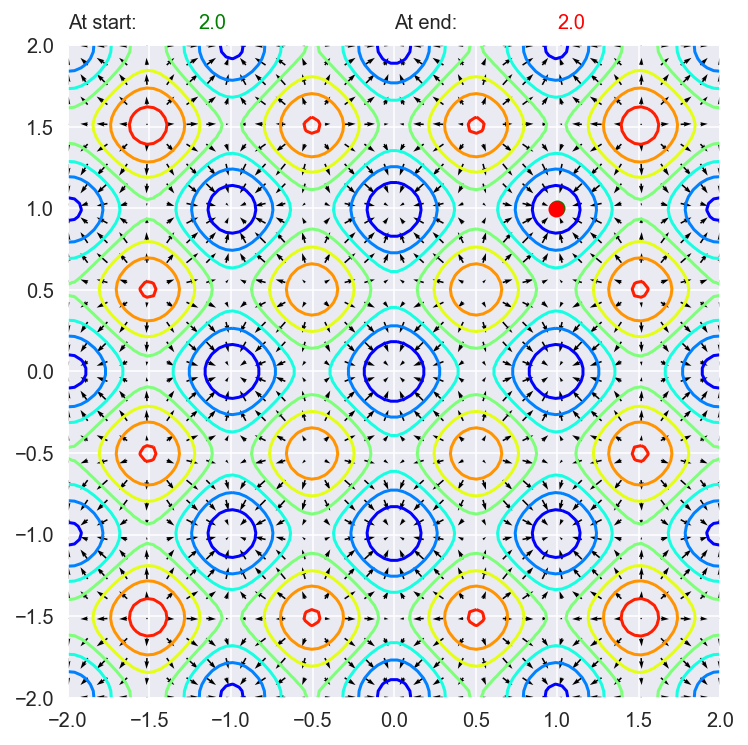

In [8]:
# Matplotlib Trajectory Explorer

def rastrigin(xy):
    z = (xy[0]**2 - 10 * np.cos( 2 * np.pi * xy[0]) ) + \
    (xy[1]**2 - 10 * np.cos( 2 * np.pi * xy[1] ) ) + 20
    return(z)

def grad_rastrigin(coord):
    x = coord[0]
    y = coord[1]
    zx = (2*x + 20 * np.pi * np.sin( 2 * np.pi * x ) )
    zy = (2*y + 20 * np.pi * np.sin( 2 * np.pi * y ) )
    grad = np.array([zx,zy])
    return(grad)

xlim = -2 # usually 5.12
ylim = -2 # usually 5.12
x = np.linspace(-xlim, xlim, 100)     
y = np.linspace(-ylim, ylim, 100)     
X, Y = np.meshgrid(x, y) 
Z = rastrigin(np.array([X,Y]))
dXdY = -grad_rastrigin(np.array([X,Y]))
dX = dXdY[0]
dY = dXdY[1]

def descend( xy0 ):
    nsteps = 100
    xy = np.zeros([nsteps,2])
    xy[0,:] = xy0
    for i in range(1,nsteps):
        xy[i,:] = xy[i-1,:] - .001*grad_rastrigin( xy[i-1,:] )
    return (xy)

x0 = 1; y0 = 1;
trajectory = descend( np.array( [x0,y0] ) )
zstart = rastrigin(trajectory[0,:])
zend = rastrigin(trajectory[-1,:])

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_aspect(1.0)
plt.contour(X,Y,Z,cmap=cm.jet)
pt, = plt.plot(x0,y0,'g.',markersize = 14)
traj, = plt.plot(trajectory[:,0],trajectory[:,1],'k')
pt2, = plt.plot(trajectory[-1,0],trajectory[-1,1],'r.',markersize = 14)

q = ax.quiver(X[::3,::3], Y[::3,::3], dX[::3,::3], dY[::3,::3])
ax.quiverkey(q, X=0.3, Y=10.1, U=10,label = '')

num2str = '{0:.{1}f}'.format
txt = plt.text(-2,2.1,'At start: ')
txt2 = plt.text(-1.2,2.1,num2str(zstart,1),color='green')
txt3 = plt.text(0,2.1,'At end: ')
txt4 = plt.text(1,2.1,num2str(zend,1),color='red')


def onclick(event):
    x0 = event.xdata
    y0 = event.ydata
    trajectory = descend( np.array( [x0,y0] ) )
    pt.set_xdata(trajectory[0,0])
    pt.set_ydata(trajectory[0,1])
    pt2.set_xdata(trajectory[-1,0])
    pt2.set_ydata(trajectory[-1,1])
    traj.set_xdata(trajectory[:,0])
    traj.set_ydata(trajectory[:,1])
    zstart = rastrigin(trajectory[0,:])
    zend = rastrigin(trajectory[-1,:])    
    txt2.set_text(num2str(zstart,1))
    txt4.set_text(num2str(zend,1))

cid = fig.canvas.mpl_connect('button_press_event', onclick)